In [1]:
import torch
from torch import nn
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt

$$
\newcommand{\RR}{\mathbb{R}}
\newcommand{\ZZ}{\mathbb{Z}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\Zz}{\mathcal{Z}}
\newcommand{\Ww}{\mathcal{W}}
\newcommand{\Vv}{\mathcal{V}}
\newcommand{\Nn}{\mathcal{N}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\Hh}{\mathcal{H}}
\newcommand{\Bb}{\mathcal{B}}
\newcommand{\Ee}{\mathcal{E}}
\newcommand{\Cc}{\mathcal{C}}
\newcommand{\Gg}{\mathcal{G}}
\newcommand{\Ss}{\mathcal{S}}
\newcommand{\Pp}{\mathcal{P}}
\newcommand{\Ff}{\mathcal{F}}
\newcommand{\Xx}{\mathcal{X}}
\newcommand{\Mm}{\mathcal{M}}
\newcommand{\Ii}{\mathcal{I}}
\newcommand{\Dd}{\mathcal{D}}
\newcommand{\Ll}{\mathcal{L}}
\newcommand{\Tt}{\mathcal{T}}
\newcommand{\al}{\alpha}
\newcommand{\la}{\lambda}
\newcommand{\ga}{\gamma}
\newcommand{\Ga}{\Gamma}
\newcommand{\La}{\Lambda}
\newcommand{\si}{\sigma}
\newcommand{\Si}{\Sigma}
\newcommand{\be}{\beta}
\newcommand{\de}{\delta}
\newcommand{\De}{\Delta}
\renewcommand{\phi}{\varphi}
\renewcommand{\th}{\theta}
\newcommand{\om}{\omega}
\newcommand{\Om}{\Omega}
\newcommand{\eps}{\varepsilon}
\newcommand{\bo}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\bu}{\bo{u}}
\newcommand{\bv}{\bo{v}}
\newcommand{\bV}{\bo{V}}
\newcommand{\bC}{\bo{C}}
\newcommand{\bp}{\bo{p}}
\newcommand{\bq}{\bo{q}}
\newcommand{\bX}{\bo{X}}
\newcommand{\bc}{\bo{c}}
\newcommand{\bb}{\bo{b}}
\newcommand{\bh}{\bo{h}}
\newcommand{\by}{\bo{y}}
\newcommand{\lc}{\bo{L}(\bC)}
\newcommand{\lcb}[1]{\bo{L}(\bo{#1})}
\newcommand{\ba}{\bo{a}}
\newcommand{\bbv}{\bo{b}}
\newcommand{\tD}{\bo{\widetilde{D}}}
\newcommand{\tLa}{\bo{\widetilde{\La}}}
\newcommand{\tCbe}{\bo{\widetilde{C}^{\be}}}
\newcommand{\bbe}{\bo{\beta}}
\newcommand{\Cbe}{\bC^{\bbe}}
\newcommand{\bhat}{\bo{\hat{\be}}}
\newcommand{\pibe}{\bpi^{\bbe}}
\newcommand{\bD}{\bo{D}}
\newcommand{\bZ}{\bo{Z}}
\newcommand{\bF}{\bo{F}}
\newcommand{\bA}{\bo{A}}
\newcommand{\bB}{\bo{B}}
\newcommand{\bK}{\bo{K}}
\newcommand{\bI}{\bo{I}}
\newcommand{\bS}{\bo{S}}
\newcommand{\bLa}{\bo{\La}}
\newcommand{\ctilde}{\bo{\tilde{c}}}
\newcommand{\ptilde}{\bo{\tilde{p}}}
\newcommand{\bhatK}{\bo{\hat{K}}}
\newcommand{\bR}{\bo{R}}
\newcommand{\bAb}{\bo{\bar{A}}}
\newcommand{\bbb}{\bo{\bar{b}}}
\newcommand{\ut}{u_{<t}}
\newcommand{\norm}[1]{\|#1\|}
\newcommand{\clint}[1]{\left[ #1 \right]}
\newcommand{\diff}{\mathop{}\!\mathrm{d}}
\newcommand{\dotp}[1]{\left\langle #1 \right\rangle}
\newcommand{\bx}{\bo{x}}
$$


# S4 in Pytorch.

## Introduction

This notebook aims at explaining the S4 layer described in [S4](https://arxiv.org/abs/2111.00396), with more details on practical use cases, as well as a simple Pytorch implementation.
Some parts of this code are directly coming from the excellent guide [Annotated S4](https://srush.github.io/annotated-s4/).

The goal of the notebook is to be as concise as possible while providing enough details for a full comprehension of a practical implementation of S4.

## Modelisation

### Classical approaches

Deep NLP has made huge progress since the arrival of the sequence-to-sequence models. A sequence-to-sequence model is a model that maps a sequence $u_0, \dots, u_{L-1}$ to another sequence $y_0, \dots, y_{L-1}$.

The main approaches in NLP were first RNN, that mimics Hidden Markov Process. In simple terms, a RNN models a situation recursively:

\begin{equation}
    \begin{cases}
        h_{k+1} &=& g(u_{k+1}, h_k),\\
        y_{k+1} &=& f(h_{k+1}).
    \end{cases}
\end{equation}
where $h_k$ represents a hidden state. Here each output $y_k$ is built recursively on the precedent value $h_{k-1}$. The main drawbacks of such models is that it is extremely difficult control how the information of previous steps flows up to the current step. It has even been derived that statistically such networks doesn't have long-memory (i.e the output at step $k$ is unlikely to have retained information of $u_{k-l}$if $l$ is large enough).

The other and currently SOTA architecture is the transformer.

Transformers are extremelly powerful because the output sequence depends directly on *all* the previous steps:

\begin{equation}
    y_{k+1} = \sum_{i=0}^{k} f(u_i, u_{k+1}).
\end{equation}

Therefore they do have long-memory. But here the problem comes form the memory consumption of such operation. To process a full sequence the memory complexity is $\mathcal{O}(L^2)$.

### State-space approach

To overcome these problems, S4 introduces the formalism of state-space models. Here $u_k \in \RR$ is a scalar input.

\begin{equation}\label{eq:state-space}
    \begin{cases}
        x_{k+1} = \bA x_k + \bb u_k,\\
        y_{k+1} = \bc^T x_{k+1}.
    \end{cases}
\end{equation}
where $x_k \in \RR^N$ is a vector and obviously $\bc \in \RR^N$. For multidimensionnal inputs, we simply apply these steps (with the same parameters) independently to all coordinates.

Let's write a first implementation of such a model.

In [2]:
class BaseSSM:
    def __init__(self, A, b, c):
        self.A = A
        self.b = b
        self.c = c

In [3]:
class SimpleSSM(BaseSSM):
    def __call__(self, u, L):

        y = torch.zeros(L)
        x_k = 0
        for i in range(L):
            x_k += b * u[i]
            y_k = self.c.T @ x_k
            y[i] = y_k
            x_k = self.A @ x_k
        return y

In [4]:
N = 10
L = 5

A = torch.randn(N, N)
b = torch.rand(N, 1)
c = torch.rand(N, 1)

In [5]:
simple_ssm = SimpleSSM(A, b, c)

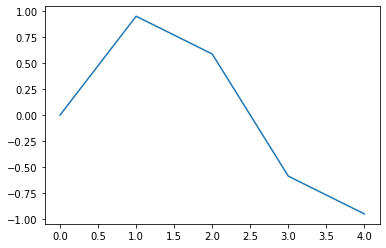

In [6]:
seq_interval = torch.arange(L)
u = torch.sin(2 * torch.pi * torch.arange(L) / L)
plt.plot(u)

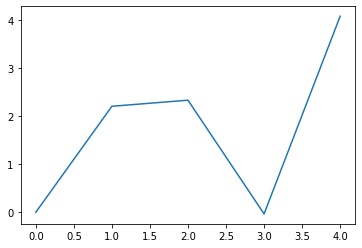

In [7]:
y = simple_ssm(u, L)
plt.plot(y)

## State-space computations

Now let's take a step back and remember that our goal is to train a model, whose parameters will include $\bA, \bb, \bc$.

However if the formulation of \eqref{eq:state-space} seems simple, it is in fact quite complicated for training, due do its recursive definition (same problems faced during training of RNN actually).

A big advantage of transformers is the possibility to process in parallel the whole sequence, that greatly improves the training speed and the backpropagation of the gradient is more easy than with recursive architectures.

Hence a legitimate question is: do we have the same property with S4? And the answer is yes!

To explain it, we are now going to focus exclusively on training, i.e when the full input and output are already available. Later, we will explain how we can generate outputs in an autoregressive manner.

## Training - Convolution view

One can notice that if we unrol \eqref{eq:state-space}, $y \in \RR^L$ can be directly expressed as a convolution between the input $u \in \RR^L$ and a filter $\bK \in \RR^L$:

\begin{align}
    y_0 &= \bc^T\bb u_0,\\
    y_1 &= \bc^T\bA\bb u_0 + \bc^T\bb u_1,\\
    y_2 &= \bc^T \bA^2 \bb u_0 + \bc^T\bA\bb u_1 + \bc^T\bb u_2,\\
    \vdots\\
    y_k &= \sum_{i=0}^k \bc^T\bA^i\bb u_{k - i}.
\end{align}

We have therefore: $y = \bK * u$, with $\bK = \left(\bc^T \bb, \bc^T\bA\bb, \dots, \bc^T\bA^{L-1}\bb\right)$.

Good news: a convolution can be computed in $\mathcal{O}(L \log L)$ once the filter $\bK$ is known, using Discrete Fourier Transform (with padding to avoid circular convolution).

Compared to the quadratic complexity of transformers, we have a huge gain in term of memory usage.

Let's write a first function to see what it gives.

*Remark:* In the following code you will see some functions characteristic of hermitian product in a complex vector space. This is because later we will work in $\CC^N$ instead of $\RR^N$. For now you can ignore it and just think of `c.H` as `c.T` for the adjoint operator and ignore `c.conj()` (that we use sometimes to compute the adjoint operator indirectly).

But sometimes some operations are also needed because of floating points error (like taking the real part after inverse Fourier Transform). When there is ambiguity we will write some comments in the code.

In [8]:
def kernel_simple(A, b, c, L):
    K = [(c.H @ A.matrix_power(l) @ b).item() for l in range(L)]
    return torch.tensor(K)

def causal_convolution(u, K):
    convolution_shape = u.shape[0] + K.shape[0]
    
    # Specifying the paramter 'n' will automatically pad our vectors to the right dimension.
    u_fft = torch.fft.fft(u, n=convolution_shape)
    K_fft = torch.fft.fft(K, n=convolution_shape)
    out = u_fft * K_fft

    # This will give complex outputs.
    return torch.fft.ifft(out)[: u.shape[0]]

In [9]:
class SimpleConvSSM(BaseSSM):
    
    def __call__(self, u, L):
    
        K = kernel_simple(self.A, self.b, self.c, L)
        y = causal_convolution(u, K)
        return y

In [10]:
simple_conv_ssm = SimpleConvSSM(A, b, c)
y_conv = simple_conv_ssm(u, L)

In [11]:
assert torch.allclose(y.type(torch.complex64), y_conv, atol=1e-3) # we need to cast y to complex type.

But the main bottleneck of this computation is how we obtain the convolution kernel. We exponentiate a matrix $L$ times, compute a lot of matrix products etc, which is highly non efficient and non stable from a numerical point of view.

To make this more efficient, we can find more sophisticated algorithms.

Namely, instead of computing directly $\bK$, we are going to compute its DFT, $\bhatK$ and then simply apply a inverse Fourier Transform (IDFT). Let $\om_k = \exp\left(-{\dfrac{2i \pi k}{N}}\right)$.

\begin{align}\label{eq:K-spectrum}
    \bhatK_k &= \sum_{i=0}^{L-1} \bK_i \omega_k^i,\\
    &= \sum \bc^T A^i b \omega_k^i,\\
    &= \bc^T \left(\sum \bA^i \omega_k^i \right) \bb,\\
    &= \bc^T (\bI - \bA^L)(\bI - \bA\omega_k)^{-1} \bb.
\end{align}

But this does not really reduce the complexity, because now we have to compute an inverse $L$ times (for each $\om_k$), giving a complexity of $\mathcal{O}(LN^3)$.



## Discretization and special decomposition

TLDR: Instead of directly dealing with the matrices $\bA$ and $\bb$ we are going to use slightly modified versions $\bAb, \bbb$. This is because of a discretization process.

\begin{equation}
    \begin{cases}
        \bAb &= \left(\bI - \dfrac{1}{2}\bA \right)^{-1}\left(\bI + \dfrac{1}{2}\bA\right),\\
        \bbb &= \left(\bI - \dfrac{1}{2}\bA \right)^{-1}\bb.
    \end{cases}
\end{equation}

In [12]:
def discretize(A, b, step=1):
    I = torch.eye(A.shape[0])
    left_term = torch.linalg.inv(I - (step / 2.0) * A)
    A_bar = left_term @ (I + (step / 2.0) * A)
    b_bar = (left_term * step) @ b
    return A_bar, b_bar

We can also assume that $\bA$ is similar to a matrix of the form $\bLa - \bp^* \bp$, where we now considerate matrix and vectors with coefficients in $\CC$.
Where $\bLa \in \CC^{N \times N}$ is diagonal and $\bp \in \CC^{N \times 1}$.
$.^*$ designated the hermitian adjoint (= transpose + conjugate) of a matrix (a vector is viewed as a matrix of $\CC^{N \times 1}$).
This decomposition is called Diagonal Plus Low Rank (DPLR).

*Remark:* In the original article the derivations are made with $\bA \sim \bLa + \bq^* \bp$. But in practice in S4 we use $-\bp = \bq$ which is valid and works better for numerical reasons.

Indeed, the matrix $A$ we are using can be decomposed in the following form:
\begin{equation}
    \bA = - \dfrac{1}{2}\bI - \bS - \bp^*\bp,
\end{equation}
where $\bS$ is a skew-hermitian matrix ($\bS = - \bS^*$), and $\bp \in \RR^{N}$ is a vector of dimension 1.

And in the adapted basis, the inverse of a DLPR matrix is much more easy to compute, thanks to the Woodburry inversion formula:

\begin{equation}
    (\bLa - \bp^* \bq)^{-1} = \bLa^{-1} + \bLa^{-1}\bp \left(1 - \bq^*\bLa^{-1} \bp\right)^{-1}\bq^* \bLa^{-1}.
\end{equation}

If we apply this result to the expression of $\bhatK$ \eqref{eq:K-spectrum} using $\bAb$ and $\bbb$, with some more algebraic operations, we obtain a quite simple formula for its expression:

\begin{equation}
    \bhatK_k = \dfrac{2}{1 + \om_k}\left[\ctilde^* \bR_k \bb - \ctilde^* \bR_k \bp (1 + \bp^*\bR_k \bp)^{-1}\bp^*\bR_k \bb\right].
\end{equation}

with $\bR_k = \left(2\dfrac{1 - \om_k}{1 + \om_k} - \bLa \right)^{-1}$ and $\ctilde^* = \bc^* (\bI - \bAb^L)$.

And here, in fact all the matrix multiplications can be evaluated very efficiently.


\begin{align}\label{eq:cauchy-K}
   \ctilde^T \bR_k \bb &= \sum_{i=1}^{N} \dfrac{\ctilde_i \bb_i}{\om_k - \bLa_i},
\end{align}

and because we want to compute it for all $\om_k$, the complexity reduces to $\mathcal{O}(NL)$.
In fact, we can be even more efficient, but we need to rely on algorithms that are not yet implemented on Pytorch.
But notice that this complexity is not a bottleneck when the biggest memory cost comes from the size of the sequence.

Computing operation \eqref{eq:cauchy-K} for all $k$ is actually a Cauchy product, a well studied problem in the litterature. We are going to implement it in a naive way, but again it won't be the main bottleneck of our model.

In [13]:
def compute_c_tilde(A, c, L):
    I = torch.eye(A.shape[0])
    
    # .H returns the adjoint operator (equivalent to transpose with real inputs).
    return (I - A.matrix_power(L)).H @ c

def cauchy(p, q, Lambd, omega_L):
    omega_L = 2. * ((1. - omega_L) / (1 + omega_L))
    
    dot_product = p.conj() * q

    Lambd = Lambd[:, None]
    omega_L = omega_L[None, :]
    cauchy_product = dot_product / (omega_L - Lambd)
    return cauchy_product.sum(axis=-2)

def kernel_dplr(Lambd, p, b, c_tilde, L):
    omega_L = torch.exp((-2j * torch.pi) * torch.arange(L) / L)
    term_1 = cauchy(c_tilde, b, Lambd, omega_L)
    term_2 = cauchy(c_tilde, p, Lambd, omega_L)
    term_3 = 1. / (1. + cauchy(p, p, Lambd, omega_L))
    term_4 = cauchy(p, b, Lambd, omega_L)
    
    K_fft = (2. / (1. + omega_L)) * (term_1 - term_2 * term_3 * term_4) 
    return torch.fft.ifft(K_fft, L)



In [14]:
# Create a random DPLR decomposition.
Lambd = -torch.rand(N, dtype=torch.complex64) # use negative real parts to get more stability
p = torch.randn(N, 1, dtype=torch.complex64)
b = torch.randn(N, 1, dtype=torch.complex64)
c = torch.randn(N, 1, dtype=torch.complex64)

A = torch.diag(Lambd) - p @ p.H
A_bar, b_bar = discretize(A, b)
c_tilde = compute_c_tilde(A_bar, c, L)
    

In [15]:
# Check if the computations of the kernel yields the same result than with a naive approach.
K_dplr = kernel_dplr(Lambd, p, b, c_tilde, L)
K_simple = kernel_simple(A_bar, b_bar, c, L)

In [16]:
assert torch.allclose(K_simple, K_dplr, atol=1e-4, rtol=1e-4)

In [17]:
class EfficientConvSSM(BaseSSM):
    def __init__(self, Lambd, p, b, c):
        self.Lambd = Lambd
        self.p = p
        self.b = b
        self.c = c
        
    def __call__(self, u, L):
        A = torch.diag(self.Lambd) - p @ p.H
        A_bar, _ = discretize(A, self.b)
        c_tilde = compute_c_tilde(A_bar, c, L)
        K = kernel_dplr(self.Lambd, p, b, c_tilde, L)
        y = causal_convolution(u, K)
        return y
            

In [18]:
# Compares efficient implentation with the naive one.
efficient_conv_ssm = EfficientConvSSM(Lambd, p, b, c)
y_efficient_conv = efficient_conv_ssm(u, L)

In [19]:
simple_conv_ssm = SimpleConvSSM(A_bar, b_bar, c)
y_simple_conv = simple_conv_ssm(u, L)

In [20]:
assert torch.allclose(y_efficient_conv, y_simple_conv, atol=1e-4)

## Multidimensionnal data

Until now we have supposed that our sequence $\bu$ is 1D. As said earlier, a direct way to generalize everything is to apply all this processing to all dimensions independently.

And in addition we are also going to consider a batch dimension.

In [21]:
class BaseMultiSSM:
    def __init__(self, A, b, c):
        self.A = A # (H, N, N)
        self.b = b # (H, N, 1)
        self.c = c # (H, N, 1)
        
class SimpleMultiConvSSM(BaseMultiSSM):
    def __call__(self, u, L):
        y = torch.zeros_like(u)
        for batch_dim in range(u.shape[0]):
            for hidden_dim in range(u.shape[2]):
                A_hidden = self.A[hidden_dim]
                b_hidden = self.b[hidden_dim]
                c_hidden = self.c[hidden_dim]
                K = kernel_simple(A, b, c, L)
                y[batch_dim, :, hidden_dim] = causal_convolution(u[batch_dim, :, hidden_dim], K)
        return y

Let's first vectorize the discretization step.

In [22]:
def discretize_multi(A, b, step=1):
    I = torch.eye(A.shape[1])
    left_term = torch.linalg.inv(I[None, :, :] - (step / 2.0) * A)
    A_bar = left_term @ (I + (step / 2.0) * A)
    b_bar = (left_term * step) @ b[:, :, None]
    return A_bar, b_bar.reshape(b.shape[0], -1)

def discretize_multi_simple(A, b, step=1):
    A_bar = torch.zeros_like(A)
    b_bar = torch.zeros_like(b)
    for h in range(A.shape[0]):
        A_bar[h], b_bar[h] = discretize(A[h], b[h], step=step)
    return A_bar, b_bar


In [23]:
H = 3
A = torch.randn(H, N, N)
b = torch.randn(H, N)
c = torch.randn(H, N)
A_bar, b_bar = discretize_multi(A, b)
A_bar_simple, b_bar_simple = discretize_multi_simple(A, b)

In [24]:
A_bar, b_bar = discretize_multi(A, b)
A_bar_simple, b_bar_simple = discretize_multi_simple(A, b)

assert torch.allclose(A_bar_simple, A_bar)
assert torch.allclose(b_bar, b_bar_simple)

Let's make a utility function to help us "vectorize" our unidimensionnal functions for testing (it just does a for loop but it will help us avoid repeating code).

This roughly does the same than the manual implementation of `discretize_multi_simple`.

In [25]:
def make_multi(func):
    """Makes a function handle multi dimensionnal inputs.
    This is not optimized and should only be used for testing purposes."""
    def multi_inputs(*args):
        out = []
        hidden_dim = args[0].shape[0]

        args = list(args)
        for i in range(len(args)):
            if (not isinstance(args[i], torch.Tensor)):

                args[i] = [args[i] for _ in range(hidden_dim)]

        for h in range(hidden_dim):
            out.append(func(*[input_tensor[h] for input_tensor in args]).tolist())
        return torch.tensor(out)
    return multi_inputs

Now the kernel generation.

In [26]:
def compute_c_tilde_multi(A, c, L):
    # A (H, N, N)
    # c (H, N)
    c_tilde = (torch.eye(A.shape[1])[None, :, :] - A.matrix_power(L)).mH @ c[:, :, None]
    return c_tilde.view(c_tilde.shape[0], -1)

def cauchy_multi(p, q, Lambd, omega_L):
    """Multidimensionnal Cauchy product. Basically we are just using broadcasting to generalize above function."""
    # p, q, Lambd (H, N)
    # omega_L (L,)
    omega_L = 2. * ((1. - omega_L) / (1 + omega_L))
    dot_product = p.conj() * q

    Lambd = Lambd[:, :, None]
    omega_L = omega_L[None, None, :]
    cauchy_product = dot_product[:, :, None] / (omega_L - Lambd)
    return cauchy_product.sum(axis=-2)

def kernel_dplr_multi(Lambd, p, b, c_tilde, L):
    omega_L = torch.exp((-2j * torch.pi) * torch.arange(L) / L)
    term_1 = cauchy_multi(c_tilde, b, Lambd, omega_L)
    term_2 = cauchy_multi(c_tilde, p, Lambd, omega_L)
    term_3 = 1. / (1. + cauchy_multi(p, p, Lambd, omega_L))
    term_4 = cauchy_multi(p, b, Lambd, omega_L)
    
    K_fft = (2. / (1. + omega_L[None, :])) * (term_1 - term_2 * term_3 * term_4) 
    return torch.fft.ifft(K_fft, L)

In [27]:
c_tilde = compute_c_tilde_multi(A, c, L)

compute_c_tilde_multi_simple = make_multi(compute_c_tilde)
c_tilde_simple = compute_c_tilde_multi_simple(A, c, L)

# Check if our vectorized function gives the same result than the a naive one.
assert torch.allclose(c_tilde, c_tilde_simple)

In [28]:
# Test with complex inputs, just to make sure we will be able to generalize with these kind of inputs.
p = torch.randn(H, N, dtype=torch.complex64)
p = torch.randn(H, N, dtype=torch.complex64)
q = torch.randn(H, N, dtype=torch.complex64)
Lambd = torch.randn(H, N, dtype=torch.complex64)
omega_L = torch.exp((-2j * torch.pi) * torch.arange(L) / L)

prod = cauchy_multi(p, q, Lambd, omega_L)

cauchy_multi_simple = make_multi(cauchy)
prod_simple = cauchy_multi_simple(p[:, :, None], q[:, :, None], Lambd, omega_L.expand(H, L))

assert torch.allclose(prod_simple, prod)

In [29]:
p = torch.randn(H, N, dtype=torch.complex64)
b = torch.randn(H, N, dtype=torch.complex64)
c = torch.randn(H, N, dtype=torch.complex64)
Lambd = torch.randn(H, N, dtype=torch.complex64)

K = kernel_dplr_multi(Lambd, p, b, c, L)

kernel_dplr_multi_simple = make_multi(kernel_dplr)

K_simple = kernel_dplr_multi_simple(Lambd, p[:, :, None], b[:, :, None], c[:, :, None], L)

# Compare the kernels with our vectorized and naive approaches.
assert torch.allclose(K, K_simple)

In [30]:
def causal_convolution_multi(u, K):
    fft_shape = u.shape[2] + K.shape[1]
    u_fft = torch.fft.fft(u, n=fft_shape, axis=-1)
    K_fft = torch.fft.fft(K, n=fft_shape, axis=-1)
    out = u_fft * K_fft
    return torch.fft.ifft(out, axis=-1)[:, :, :u.shape[2]]


def causal_convolution_multi_simple(u, K):
    out = torch.zeros_like(u)
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            out[i, j, :] = causal_convolution(u[i, j, :], K[j])
    return out


def test_convolution_multi(batch_size=8, seq_length=10, hidden_size=5):
    """Function to test if the multidimensionnal convolution works."""
    u = torch.randn(batch_size, hidden_size, seq_length)
    K = torch.randn(hidden_size, seq_length)    
    
    y_simple = causal_convolution_multi_simple(u, K)
    y = causal_convolution_multi(u, K)
    assert torch.allclose(y.real, y_simple, atol=1e-4)

In [31]:
test_convolution_multi()

/tmp/ipykernel_15105/3641897104.py:13: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  out[i, j, :] = causal_convolution(u[i, j, :], K[j])


Now we are ready to implement everything in a `nn.Module` class.
We have indeed a desribed a valid model whose parameters are $\bLa, \bb, \bp, \bc$.

There is however a last detail on which we should spend some time. Indeed, we are going to initialize $\bLa, \bb, \bp$ with very special values. This is also this initializatin which is going to explain why this S4 model works so well.

## HiPPO matrix

First a bit of context. In the previous section we have introduced a discretized version as well as DPLR decomposition for $\bA$. But the main contribution of the article is to provide a value of $\bA$ that will efficiently keep in memory the information on the whole sequence.

To do that, let's go back in the continuous domain and consider $u(t)$, $u \colon \RR^+ \to \RR$ a scalar continuous function. Because we are in the end interesting in autoregressive generation, let's introduce $\ut = u \mathbf{1}_{\clint{0, t}}$. And what the authors propose is to approximate this function on a polynomial basis.

For time $t$ we choose an orthogonal polynomial basis $(P_n^t)_{0\leq n \leq N-1}\in \RR_N[X]$ for the scalar product $\dotp{u, v} = \displaystyle\int_0^t u v \diff \lambda$ (typically we orthogonalize the canonical basis).

$\forall n \in [0..N-1]$ the coefficients $x_n(t)$ of the projection are simply given by:

\begin{equation}\label{eq:coefs}
    x_n(t) = \displaystyle\int_0^t u(s) P^t_n(s) \diff s.
\end{equation}

When we differentiate \eqref{eq:coefs} (see the original paper for the details), we find something that again depends on the $x_1, \dots, x_N$ and $\ut$, hence we have an ODE of the form:

\begin{equation}\label{eq:ode}
    \dfrac{d \bx}{dt}(t) = \bA \bx(s) + u(s)\bb(s),
\end{equation}
with \textbf{tractable} $\bA \in \RR^{N \times N}$ and $\bb \in \RR^N$.

At each time $t$, $\bx(t) \in \RR^N$ represents the whole function $\ut$. Hence, the memory property.

And it happens that for the Legend polynomial basis, the matrices $\bA$ and $\bb$ have a closed form expression:

\begin{array}{rrrl}
    \forall i, j \in [0..N-1], & \, \bA_{ij} & = & -
    \begin{cases}
        (2i + 1)^{1/2}(2j + 1)^{1/2} &\quad \text{if} \, i > j,\\
        i + 1 &\quad \text{if} \, i = j,\\
        0 &\quad \text{if} \, i < j,
    \end{cases}\\
    \forall i \in [0..N-1], & \, \bb_i & = & (2i + 1)^{1/2}.
\end{array}

In [32]:
def hippo_matrices(N):
    u = torch.arange(N)
    b = torch.sqrt(2 * u[:, None] + 1)
    A = b @ b.T
    A = torch.tril(A, 0)
    A = - (A - torch.diag(u))

    return A, b

In [33]:
A, b = hippo_matrices(4)
A

tensor([[-1.0000, -0.0000, -0.0000, -0.0000],
        [-1.7321, -2.0000, -0.0000, -0.0000],
        [-2.2361, -3.8730, -3.0000, -0.0000],
        [-2.6458, -4.5826, -5.9161, -4.0000]])

Note that we notice immediately that if $\ptilde = \dfrac{1}{\sqrt{2}}\bb$, then:

\begin{align}
    \bA + \ptilde \ptilde^t &= -\begin{cases}
        \dfrac{1}{2}(2i + 1)^{1/2}(2j + 1)^{1/2} &\quad \text{if} \, i > j,\\
        \dfrac{1}{2} &\quad \text{if} \, i = j,\\
        -\dfrac{1}{2}(2i + 1)^{1/2}(2j + 1)^{1/2} &\quad \text{if} \, i < j,
    \end{cases}\\
    &= -\dfrac{1}{2}\bI - \bS
\end{align}
where $\bS$ is a skew-symmetric matrix:

\begin{equation}
\bS =
\begin{cases}
        \dfrac{1}{2}(2i + 1)^{1/2}(2j + 1)^{1/2} &\quad \text{if} \, i > j,\\
        0 &\quad \text{if} \, i = j,\\
        -\dfrac{1}{2}(2i + 1)^{1/2}(2j + 1)^{1/2} &\quad \text{if} \, i < j,
\end{cases}
\end{equation}

And a skew-symmetric matrix can be diagonalized (in $\CC$), hence it means that $\bA$ is similar to a DPLR matrix!

\begin{equation}
\exists \bV \in \mathcal{O}_N(\CC),\, \bA = \bV \left( \bLa - \bp \bp^* \right) \bV^*,
\end{equation}

with $\bV$ the matrix representing the (complex) eigenvectors of $\bS$, $\mathcal{O}_N(\CC)$ the set of orthogonal matrices of size $N$ in $\CC$, and $\bp = \bV^* \ptilde$.
Note that we should not forget to also change the basis of $\bb$ when we want to use the special form $\bA = \bLa - \bp \bp^*$.

We now have everything to initialize our parameters:

- Create $\bA, \bp$ and $\bb$ with their closed form expressions.
- Instead of optimizing $\bc$ we are going to optimize $\ctilde$ which is in fact the only part where $\bc$ is used. It will help reducing the number of operations and especially avoid exponentiating $\bA$ (this is however a bit incorrect because we are losing the property that the output is real, but we can hope the neural network will learn a 'good' $\ctilde$ which in the end has this property).
- Initialize $\ctilde$ at random.
- Extract $\bS$ from $\bA$ and compute its eigenbasis.
- Change the basis of $\bp, \bb$.
- Initialize $\bD$ at random that we are going to use as a "skip connection".

From now all our vectors are going to be complex.

Let's write that in Python.

In [34]:
def hippo_matrices_dplr(N):
    u = torch.arange(N)[:, None]
    
    p_tilde = torch.sqrt(u + 0.5)

    # Construct S
    S = torch.tril(p_tilde @ p_tilde.T)
    S = - S + S.T

    # A small trick to make a skew-hermitian matrix a hermitian one.
    hermitian_S = S * -1j
    
    # Diagonalize S and extract V.
    Lambda, V = torch.linalg.eigh(hermitian_S)


    # Mutliplies back the eigenvalues by (1j)^-1 to retrieve the original eigenvalues of the skew-hermitian matrix.
    # We have to add the real parts of the eigenvalues, coming for the 1/2*Id part of the decomposition. 
    Lambda = Lambda * 1j - 0.5
    
    b = torch.sqrt(2 * u + 1)
    
    # Change of basis for b and p.
    b = V.H @ b.type(torch.complex64)
    p = V.H @ p_tilde.type(torch.complex64)
    
    return V, Lambda, p, b



In [35]:
V, Lambda, p, b = hippo_matrices_dplr(N)

Check if we did not make any mistakes in our change of basis by comparing $\bA$ obtained from the direct formula and the one obtained through diagonalization:

In [36]:
A, b = hippo_matrices(N)

assert torch.allclose(V @ (torch.diag(Lambda) - p @ p.H) @ V.H, A.type(torch.complex64), atol=1e-4)

Before getting to the full implementation, we are going to explain how we can perform autoregressive decoding.
Indeed, when doing a convolution, we assume that the whole input in known. In autoregressive decoding it is not the cae anymore. We therefore have to get back to the basic definition of the state-space system.



## Recurrent decoding
The authors derived a computation of each step in $\mathcal{O}(N)$ (instead of a naive $\mathcal{O}(N^2))$, by leveraging the DPLR form of $\bA$ with single unidimensional inputs, and $\mathcal{O}(HN)$ with H-dimensional inputs and $N$ the polynomial space dimension.

The authors derive that we can decompose $\bAb$ as the product of two DPLR matrices:

\begin{equation}
    \bAb = \bA_1 \bA_0,
\end{equation}
with:

\begin{equation}
    \bA_i = \bLa_i - \bp_i \bq_i^*.  
\end{equation}
where:
\begin{cases}
    \bLa_0 &= 2 + \bLa,\\
    \bp_0 &= \bp,\\
    \bq_0 &= \bp.
\end{cases}
and:
\begin{cases}
    \bLa_1 &= (2 - \bLa)^{-1},\\
    \bp_1 &= \bLa_1(1 + \bp^* \bLa_1 \bp)^{-1},\\
    \bq_1 &= \bp^* \bLa_1
\end{cases}


Below is the values of the matrices computed in the original paper.

In [37]:
def discrete_dplr(Lambda, p, b, step=1.):
    # Convert parameters to matrices
    N = Lambda.shape[0]
    A = torch.diag(Lambda) - p @ p.H
    I = torch.eye(N)

    # Forward Euler
    A_0 = (2.0 / step) * I + A

    # Backward Euler
    D = torch.diag(1.0 / ((2.0 / step) - Lambda))
    D_p = D @ p

    
    A_1 = D - (D_p * (1.0 / (1 + (p.H @ D_p))) * p.H @ D)

    # A bar and b bar
    A_bar = A_1 @ A_0
    b_bar = 2 * A_1 @ b

    return A_bar, b_bar

In [38]:
p = torch.randn(N, 1)
b = torch.randn(N, 1)
Lambd = torch.randn(N)

# Our new formula
A_bar_dplr, b_bar_dplr = discrete_dplr(Lambd, p, b)

# Base formula
A = torch.diag(Lambd) - p @ p.H
A_bar_closed_form, b_bar_closed_form = discretize(A, b)

assert torch.allclose(A_bar_dplr, A_bar_closed_form)

Now we can perform autoregressice decoding easily, simply by using our matrices $\bA_0, \ \bA_1$.

In [39]:
def scan_ssm(A_bar, b_bar, c, u, x_0):
    def step(x_k_1, u_k):
        x_k = A_bar @ x_k_1 + b_bar @ u_k
        y_k = c.H @ x_k
        return x_k, y_k
    recurrence = []
    x_k = x_0
    for i in range(u.shape[0]):
        x_k, y_k = step(x_k, u[i])
        recurrence.append(y_k)
    return x_k, torch.tensor(recurrence)

But with this form we do not leverage the efficiency of DPLR matrices. Indeed, the matrix-vector product of a DPLR matrix is $\mathcal{O}(N)$.
Indeed:

\begin{equation}
    (\bLa - \bp \bq^*)\bx = \bLa \bx - \bp \underbrace{(\bq^* \bx)}_{scalar}.
\end{equation}

To code this, we are simple going to need the DPLR decomposition and not the full matrix anymore.

In [40]:
def discrete_dplr_opti(Lambda, p, b, step=1):
    """DPLR of A_0 and A_1."""
    Lambda_0 = 2. / step + Lambda[:, None]
    p_0 = p
    q_0 = p
    
    Lambda_1 = 1. / ((2. / step) - Lambda[:, None])
    p_1 = Lambda_1 * p * 1. / (1. + p.H @ (Lambda_1 * p))
    q_1 = Lambda_1.conj() * p
    
    b_bar = 2 * (Lambda_1 * b - p_1 * (q_1.H @ b))

    return (Lambda_0, p_0, q_0), (Lambda_1, p_1, q_1), b_bar


In [41]:
def dplr_vector_product(dplr, x):
    """Unidimensionnal optimized dplr matrix-vector product."""
    Lambda, p, q = dplr
    diagonal_prod = Lambda * x

    lr_prod = p * (q.H @ x)
    
    return diagonal_prod - lr_prod


def scan_ssm_opti(dplr_0, dplr_1, b_bar, c, u, x_0):
    """Optimized RNN computations."""
    def step(x_k_1, u_k):
        x_k = dplr_vector_product(dplr_0, x_k_1)
        x_k = dplr_vector_product(dplr_1, x_k) + b_bar * u_k
        y_k = c.H @ x_k

        return x_k, y_k
    
    recurrence = []
    x_k = x_0
    for i in range(u.shape[0]):
        x_k, y_k = step(x_k, u[i])
        recurrence.append(y_k)
    return x_k, torch.tensor(recurrence)

We can do a big check, to see if everything is coherent.

In [42]:
def test_conversion(N=8, L=16):
    V, Lambda, p, b = hippo_matrices_dplr(N)
    
    # Compute A in closed form
    A = torch.diag(Lambda) - p @ p.H
    c_base = torch.randn(N, 1)
    
    # Change the basis of c.
    c = V.H @ c_base.type(torch.complex64)
    A_bar, b_bar = discretize(A, b)
    c_tilde = compute_c_tilde(A_bar, c, L)

    # CNN form.
    K = kernel_dplr(Lambda, p, b, c_tilde, L)

    # Simple RNN form.
    K_simple = kernel_simple(A_bar, b_bar, c, L=L)
    assert torch.allclose(K, K_simple, atol=1e-4)
    
    # New RNN form
    A_bar_new, b_bar_new = discrete_dplr(Lambda, p, b)
    K_rnn = kernel_simple(A_bar, b_bar, c, L=L)
    assert torch.allclose(K_simple, K_rnn, atol=1e-4)
    

    # Apply CNN
    u = torch.arange(L).type(torch.complex64)
    y_1 = causal_convolution(u, K)

    # Apply RNN
    _, y_2 = scan_ssm(
        A_bar, b_bar, c, u[:, None], torch.zeros((N,)).type(torch.complex64)
    )
    assert torch.allclose(y_1, y_2.reshape(-1), atol=1e-4, rtol=1e-4)
    
    # Optimized RNN form
    dplr_0, dplr_1, b_bar_opti = discrete_dplr_opti(Lambda, p, b)

    assert torch.allclose(b_bar, b_bar_opti)
    
    _, y_2_opti = scan_ssm_opti(dplr_0, dplr_1, b_bar_opti, c, u[:, None], torch.zeros((N, 1)).type(torch.complex64))
    assert torch.allclose(y_1, y_2_opti.reshape(-1), atol=1e-4, rtol=1e-4)

In [43]:
test_conversion()

We are almost done. We now need to adapt it to handle multidimensional inputs, as well as a batch dimension.

In [44]:
def discrete_dplr_opti_multi(Lambda, p, b, step=1):
    """DPLR of A_0 and A_1 with multidimensionnal data."""
    
    # Lambda (H, N)
    # p, b (H, N)
    Lambda_0 = 2. / step + Lambda
    p_0 = p
    q_0 = p
    
    Lambda_1 = 1. / ((2. / step) - Lambda)
    p_1 = Lambda_1 * p * 1. / (1. + (p.conj() * Lambda_1 * p).sum(axis=-1, keepdim=True))
    q_1 = Lambda_1.conj() * p
    
    b_bar = 2 * (Lambda_1 * b - p_1 * (q_1.conj() * b).sum(axis=-1, keepdim=True))

    return (Lambda_0, p_0, q_0), (Lambda_1, p_1, q_1), b_bar

def dplr_vector_product_multi(dplr, x):
    # x (B, H, N)
    # Lambda (H, N)
    # p, q (H, N)
    
    Lambda, p, q = dplr
    diagonal_prod = Lambda[None, :, :] * x
    lr_prod = p[None, :, :] * (q[None, :, :].conj() * x).sum(axis=2, keepdims=True)
    
    return diagonal_prod - lr_prod

def dplr_vector_prod_multi_simple(dplr, x):
    """Naive version of dplr matrix-vector product."""
    out = torch.zeros_like(x)
    Lambda, p, q = dplr
    for i in range(x.shape[0]):
        for h in range(x.shape[1]):
            prod = dplr_vector_product((Lambda[h][:, None], p[h][:, None], q[h][:, None]), x[i, h][:, None]).view(-1)
            out[i, h] = prod
    return out

In [45]:
def make_dplr_random(N):
    Lambda = torch.randn(N, 1)
    p = torch.randn(N, 1)
    q = torch.randn(N, 1)
    
    return Lambda, p, q

def make_dplr_random_multi(H, N):
    Lambda = torch.randn(H, N)
    p = torch.randn(H, N)
    q = torch.randn(H, N)
    
    return Lambda, p, q

In [46]:
H = 3
N = 5
x = torch.randn(8, H, N)
Lambda, p, q = make_dplr_random_multi(H, N)
dplr = Lambda, p, q

Check if our vectorized dplr matrix vector product works.

In [47]:
dplr_prod = dplr_vector_product_multi(dplr, x)
dplr_prod_simple = dplr_vector_prod_multi_simple(dplr, x)

assert torch.allclose(dplr_prod, dplr_prod_simple, atol=1e-4)

In [48]:
def scan_ssm_opti_multi(dplr_0, dplr_1, b_bar, c, u, x_0):
    # b_bar (H, N)
    # c (H, N)
    # u (B, H, L)
    # x_0 (B, H, N)
    
    def step(x_k_1, u_k):
        x_k = dplr_vector_product_multi(dplr_0, x_k_1)

        x_k = dplr_vector_product_multi(dplr_1, x_k) + b_bar[None, :, :] * u_k[:, :, None]
        y_k = (c[None, :, :].conj() * x_k).sum(axis=-1, keepdim=True)

        return x_k, y_k
    recurrence = []
    x_k = x_0
    for i in range(u.shape[-1]):
        x_k, y_k = step(x_k, u[:, :, i])
        recurrence.append(y_k)

    return x_k, torch.cat(recurrence, axis=-1)

In [49]:
def scan_ssm_opti_multi_simple(dplr_0, dplr_1, b_bar, c, u, x_0):
    """Naive version of scan ssm multi."""
    Lambda_0, p_0, q_0 = dplr_0
    Lambda_1, p_1, q_1 = dplr_1
    
    batch_size = u.shape[0]
    hidden_size = u.shape[1]
    
    out = torch.zeros_like(u)
    for i in range(batch_size):
        for h in range(hidden_size):
            dplr_h_0 = Lambda_0[h][:, None], p_0[h][:, None], q_0[h][:, None]
            dplr_h_1 = Lambda_1[h][:, None], p_1[h][:, None], q_1[h][:, None]
            out[i, h] = scan_ssm_opti(dplr_h_0, dplr_h_1, b_bar[h][:, None], c[h][:, None], u[i, h][:, None], x_0[i, h][:, None])[-1]
    return None, out

In [50]:
H = 5
N = 10
B = 4
L = 3
dplr_0 = make_dplr_random_multi(H, N)
dplr_1 = make_dplr_random_multi(H, N)
x_0 = torch.zeros(B, H, N)
u = torch.randn(B, H, L)
b_bar = torch.randn(H, N)
c = torch.randn(H, N)

_, scan_simple = scan_ssm_opti_multi_simple(dplr_0, dplr_1, b_bar, c, u, x_0)
_, scan = scan_ssm_opti_multi(dplr_0, dplr_1, b_bar, c, u, x_0)

assert torch.allclose(scan, scan_simple, atol=1e-4)

In [51]:
def test_conversion_multi(B=4, H=10, N=8, L=5):
    V, Lambda, p, b = hippo_matrices_dplr(N)
    
    # Compute A in closed form.
    A = torch.diag(Lambda) - p @ p.H
    
    # Make H copies of A, p, b, Lambda.
    A = A.expand(H, N, N).clone()
    p = p.squeeze().expand(H, N).clone()
    b = b.squeeze().expand(H, N).clone()
    Lambda = Lambda.squeeze().expand(H, N).clone()
    
    # Initialize H c.
    c_base = torch.randn(H, N)
    
    # Change the basis of c.
    c = V.H @ c_base[:, :, None].type(torch.complex64)
    c = c.view(H, N)
    
    # Get A_bar (needed for c_tilde).
    A_bar, b_bar = discretize_multi(A, b)
    
    
    # Compute c_tilde
    c_tilde = compute_c_tilde_multi(A_bar, c, L)

    # CNN form. Check again if our vectorized computations give the same result as a naive one.
    K = kernel_dplr_multi(Lambda, p, b, c_tilde, L)
    K_simple = kernel_dplr_multi_simple(Lambda, p[:, :, None], b[:, :, None], c_tilde[:, :, None], L)
    
    assert torch.allclose(K, K_simple, atol=1e-4)
    
    # Create an input signal with a batch size, a hidden size and a sequence length.
    
    u = torch.randn(B, H, L).type(torch.complex64)
    
    # Apply CNN
    y_cnn = causal_convolution_multi(u, K)

    # Apply RNN
    # Optimized RNN form
    dplr_0, dplr_1, b_bar_opti = discrete_dplr_opti_multi(Lambda, p, b)
    
    # Check if we obtain the same b_bar than with the closed form formula.
    assert torch.allclose(b_bar, b_bar_opti)
    
    # Apply RNN autoregressively,
    _, y_rnn = scan_ssm_opti_multi(
        dplr_0, dplr_1, b_bar_opti, c, u, torch.zeros((N,)).type(torch.complex64)
    )
    
    # Compare with CNN output.
    assert torch.allclose(y_cnn, y_rnn, atol=1e-4, rtol=1e-4)

In [52]:
test_conversion_multi()

Done! We now have everything to implement our model within a Pytorch module.